In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
parent_path = str(Path().joinpath('..\..').resolve())
sys.path.append(parent_path)

In [3]:
from triple_agent.parsing.replay.get_parsed_replays import get_parsed_replays
from triple_agent.constants.events import select_sc19
from triple_agent.reports.specific.character_selection import (spy_selection,
                                                      st_selection,
                                                      amba_selection,
                                                      double_agent_selection,
                                                      determine_character_in_role)
from triple_agent.reports.specific.game_outcomes import game_outcomes
from triple_agent.classes.roles import Roles
from triple_agent.classes.outcomes import WinType
from triple_agent.classes.missions import Missions, MissionStatus
from triple_agent.reports.generation.common_sort_functions import sort_by_spy_wins, sort_by_sniper_wins
from triple_agent.reports.generation.plot_specs import AxisProperties, DataQueryProperties, PlotLabelStyle
from triple_agent.reports.specific.action_tests import action_test_percentages, diff_action_test_percentages
from triple_agent.reports.specific.mission_choices import mission_choices
from triple_agent.reports.specific.mission_completes import mission_completion_query, mission_completion, _mission_completes_details
from triple_agent.classes.action_tests import ActionTest
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import linregress

In [4]:
replays = get_parsed_replays(lambda g: True)

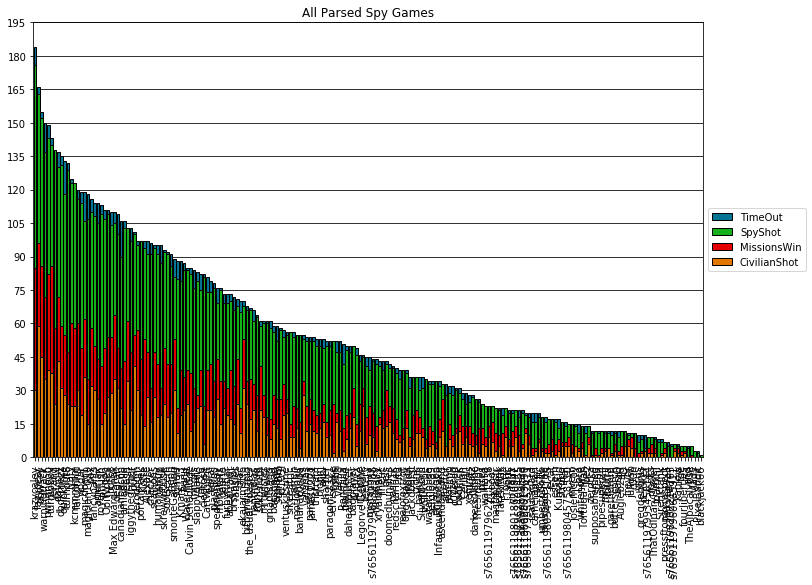

In [5]:
all_spy_games = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=sum,
        reverse_secondary_order=True,
    ),
    axis_properties=AxisProperties(title="All Parsed Spy Games")
)

This will keep only spies with > 10 games played.

In [6]:
qualifying_spies = all_spy_games.frame.drop([col for col, val in all_spy_games.frame.sum().iteritems() if val < 10], axis=1).keys()

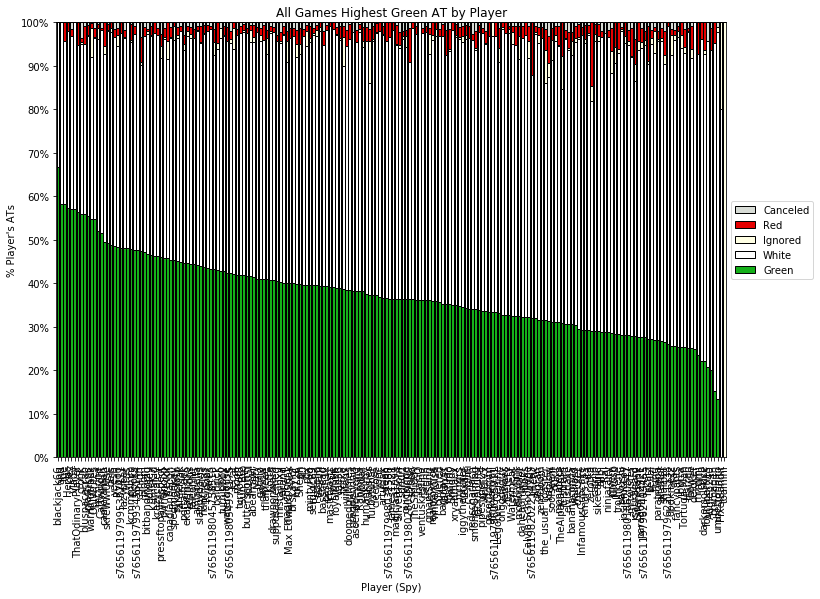

In [7]:
spy_at_rate = action_test_percentages(
    replays,
    axis_properties = AxisProperties(
        title='All Games Highest Green AT by Player',
        x_axis_label='Player (Spy)',
        y_axis_label='% Player\'s ATs',
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=lambda name_series: -name_series[1][ActionTest.Green],
        reverse_primary_order=True,
        percent_normalized_data=True)    
)

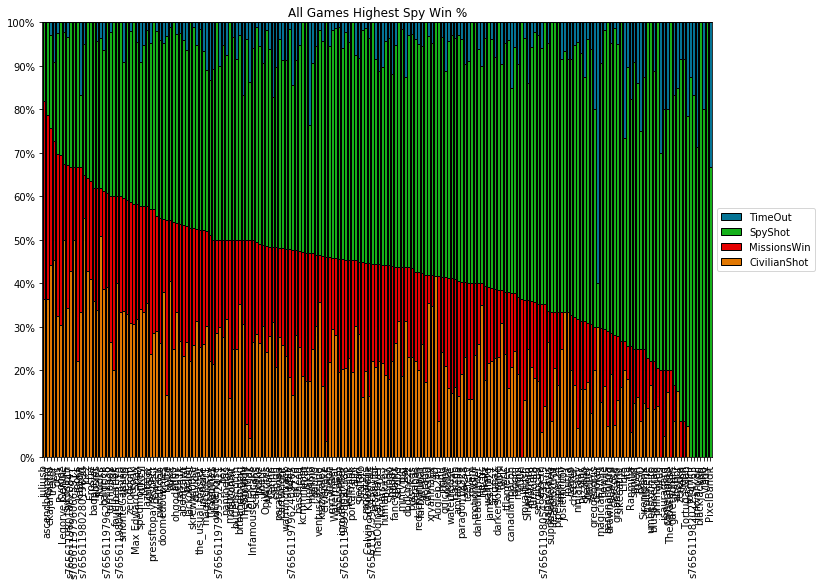

In [8]:
spy_outcome_rates = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=sort_by_spy_wins,
        reverse_secondary_order=True,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="All Games Highest Spy Win %")
)

In [9]:
spy_winrates = spy_outcome_rates.frame.loc[WinType.MissionsWin] + spy_outcome_rates.frame.loc[WinType.CivilianShot]

In [11]:
spy_winrates_trimmed = spy_winrates.filter(items=qualifying_spies)

In [12]:
spy_at_rate_trimmed = spy_at_rate.frame.filter(items=qualifying_spies)

In [13]:
at_values = spy_at_rate_trimmed.loc[ActionTest.Green].sort_index().values
winrate_values = spy_winrates_trimmed.sort_index().values

In [14]:
slope, intercept, r_value, p_value, std_err = linregress(at_values, winrate_values)

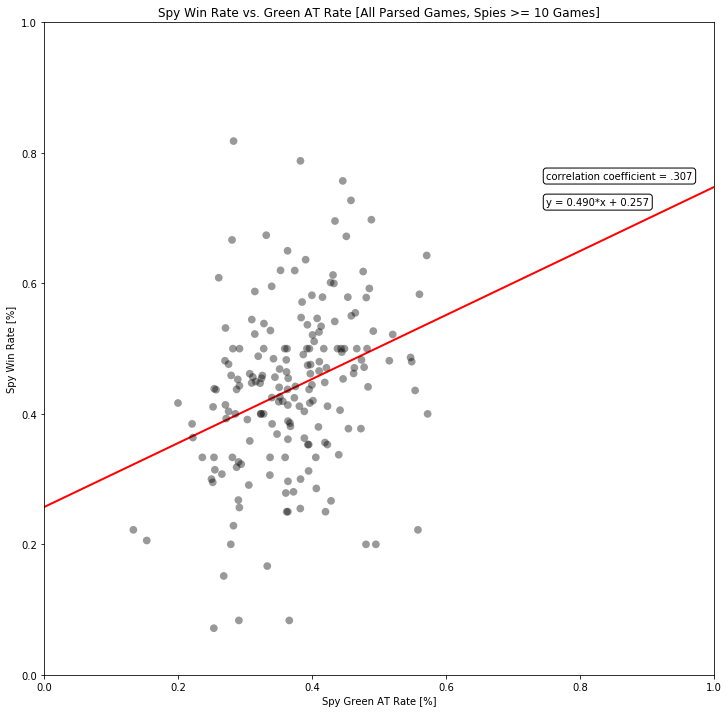

In [15]:
fig, ax  = plt.subplots(figsize=(12,12), facecolor='white')
ax.plot([0, 1], [intercept, intercept + slope], color='r', linewidth=2, zorder=-1)
ax.scatter(at_values, winrate_values, alpha=.4, color='k', s=60, edgecolors='none')
ax.set_ylabel('Spy Win Rate [%]')
ax.set_xlabel('Spy Green AT Rate [%]')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title('Spy Win Rate vs. Green AT Rate [All Parsed Games, Spies >= 10 Games]')
ax.annotate("y = 0.490*x + 0.257", (.75, .72), bbox=dict(boxstyle="round", fc="1"))
ax.annotate("correlation coefficient = .307", (.75, .76), bbox=dict(boxstyle="round", fc="1"))
plt.show()

In [16]:
def purloin_at(game):
    name = ActionTest.NoAT.name
    for t in game.timeline:
        if (t.action_test != ActionTest.NoAT) and (t.mission == Missions.Purloin):
            name = t.action_test.name
            break
    return name

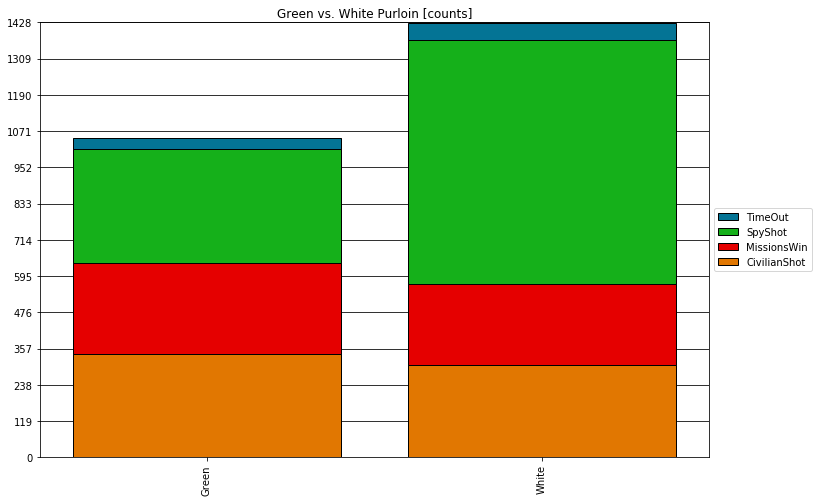

,Green,White
WinType.TimeOut,36,56
WinType.SpyShot,373,801
WinType.MissionsWin,301,267
WinType.CivilianShot,338,302


In [17]:
game_outcomes(
    list(filter(lambda g: Missions.Purloin in g.completed_missions, replays)),
    DataQueryProperties(
        groupby=purloin_at,
        secondary_order=['Green', 'White'],
    ),
    axis_properties=AxisProperties(title="Green vs. White Purloin [counts]")
).frame

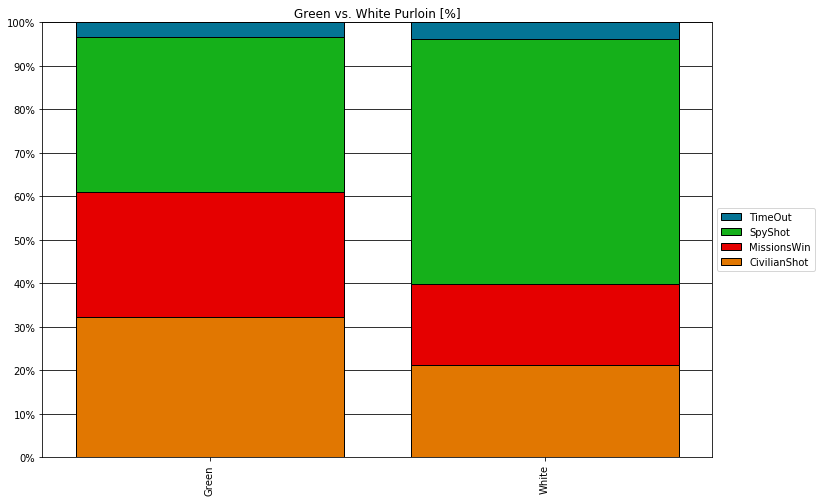

,Green,White
WinType.TimeOut,0.034351,0.039271
WinType.SpyShot,0.355916,0.561711
WinType.MissionsWin,0.287214,0.187237
WinType.CivilianShot,0.322519,0.211781


In [18]:
game_outcomes(
    list(filter(lambda g: Missions.Purloin in g.completed_missions, replays)),
    DataQueryProperties(
        groupby=purloin_at,
        secondary_order=['Green', 'White'],
        percent_normalized_data=True
    ),
    axis_properties=AxisProperties(title="Green vs. White Purloin [%]")
).frame